<딥러닝 파이토치 교과서> ch5. 3 p.200~229

---
# 5.3 전이 학습
### 5.3.1 특성 추출 기법
### 5.3.2 미세 조정 기법
---

# 5.3 전이 학습
- 합성곱 신경만 기반의 딥러닝 모델을 제대로 훈련시키려면 많은 양의 데이터가 필요
- 큰 데이터셋을 확보하려면 많은 돈과 시간이 필요
- 이미지넷처럼 아주 큰 데이터셋을 써서 훈련된 모델의 가중치를 가져와 해결하려는 과제에 맞게 보정해서 사용하는 방법 : **전이 학습**

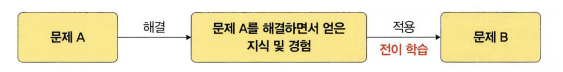

### 5.3.1 특성 추출 기법 (feature extractor)
- ImageNet 데이터셋으로 사전 훈련된 모델에서 합성곱층은 그대로 가져오고, 마지막 완전연결층 부분만 새로 만듦.
   - 합성곱층: 합성곱층과 풀링층으로 구성
   - 데이터 분류기 (완전연결층): 추출된 특성을 입력받아 최종적으로 이미지에 대한 클래스를 분류하는 부분
- 사용가능한 이미지 분류 모델엔 Xception, Inception V3, VGG16, VGG18, MobileNet 등이 있음


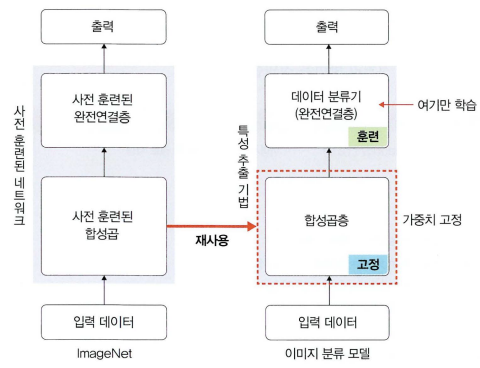

In [ ]:
# 라이브러리 설치
!pip install opencv-python

In [ ]:
# 라이브러리 호출
import os
import time
import copy
import glob
import cv2 # 앞에서 설치한 OpenCV 라이브러리
import shutil

import torch
import torchvision # 컴퓨터 비전(computer vision) 용도의 패키지
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용되는 패키지
import torchvision.models as models # 다양한 파이토치 네트워크를 사용할 수 있도록 도와주는 패키지
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [ ]:
# Github에서 리포지토리 클론
!git clone https://github.com/gilbutITbook/080289.git

Cloning into '080289'...
remote: Enumerating objects: 2278, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 2278 (delta 4), reused 27 (delta 3), pack-reused 2246 (from 1)
Receiving objects: 100% (2278/2278), 330.30 MiB | 32.92 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Updating files: 100% (2591/2591), done.


In [ ]:
# 이미지 데이터 전처리 방법 정의
data_path = '080289/chap05/data/catanddog/train' # 이미지 데이터가 위치한 경로 지정

transform = transforms.Compose(
    [
        transforms.Resize([256, 256]),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])

train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

385


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[코드 설명]
- `torchvision.transform`은 이미지 데이터를 변환하여 모델(네트워크)의 입력으로 사용할 수 있게 변환해줌.
   - Resize: 이미지의 크기를 조정. 합성곱층을 통과하기 위해 이미지 크기를 조정하는 전처리 과정.
   - RandomResizedCrop: 이미지를 랜덤한 크기 및 비율로 자름. 데이터 확장 용도로 사용됨.


   ```
   # RandomResizedCrop으로 데이터 확장하기
   pip install mxnet
   pip install --user mxnet

   # 데이터 확장 예제
   import matplotlib.pyplot as plt
   import mxnet as mx
   from mxnet.gluon.data.vision import transforms

   # RandomResizedCrop을 적용하기 위한 함수
   def show_images(imgs, num_rows, num_cols, scale=2):
      aspect_ratio = imgs[0].shape[0]/imgs[0].shape[1] # 확장할 이미지의 크기 조정
      figsize = (num_cols*scale, num_rows*scale*aspect_ratio)
      _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
      for i in range(num_rows):
         for j in range(num_cols):
         axes[i][j].imshow(imgs[i*num_cols + j].asnumpy())
         axes[i][j].axes.get_xaxis().set_visible(False) # x축 전체를 숨김
         axes[i][j].axes.get_yaxis().set_visible(False) # y축 전체를 숨김
      plt.subplots_adjust(hspace = 0.1, wspace=0)
      return axes

   def apply(img, aug, num_rows=2, num_cols=4, scale=3):
      Y = [aug(img) for _ in range(num_rows * num_cols)]
      show_images(Y, num_rows, num_cols, scale)

   # RandomResizedCrop이 적용된 이미지를 출력
   shape_aug = transforms.RandomResizedCrop(size=(200, 200), # size: 출력할 크기를 200x200으로 조정
                                            scale=(0.1, 1),  # scale: 면적 비율을 0.1~1(10~100%) 범위 내에서 무작위로 자름.
                                            ratio=(0.5, 2)) # ratio: 면적의 너비와 높이 비율을 0.5~2 범위 내에서 무작위로 조정.
   apply(example_image, shape_aug)


   ```


   - RandomHorizontalFlip: 이미지를 수평으로 뒤집음.
   - ToTensor: 이미지 데이터를 tensor로 변환함.
- `datasets.ImageFolder`: 데이터로더가 데이터를 불러올 대상과 방법(transform 혹은 전처리)을 정의
   - 첫번째 파라미터: 불러올 데이터가 위치한 경로
   - transform: 이미지 데이터에 대한 전처리
- `torch.utils.data.DataLoader`: 데이터로더 정의
   - 첫번째 파라미터: 데이터셋 지정
   - batch_size: 한번에 불러온 데이터양을 지정
   - num_workers: 데이터를 불러올 때 하위 프로세스를 몇 개 사용할지 설정. 너무 많은 하위 프로세스를 설정하면 오류가 발생하거나 메모리 부족 현상이 발생할 수 있음.
   - shuffle: 데이터를 무작위로 섞을건지 설정. shuffle=True로 설정하면 데이터를 무작위로 섞어서 랜덤으로 불러옴.

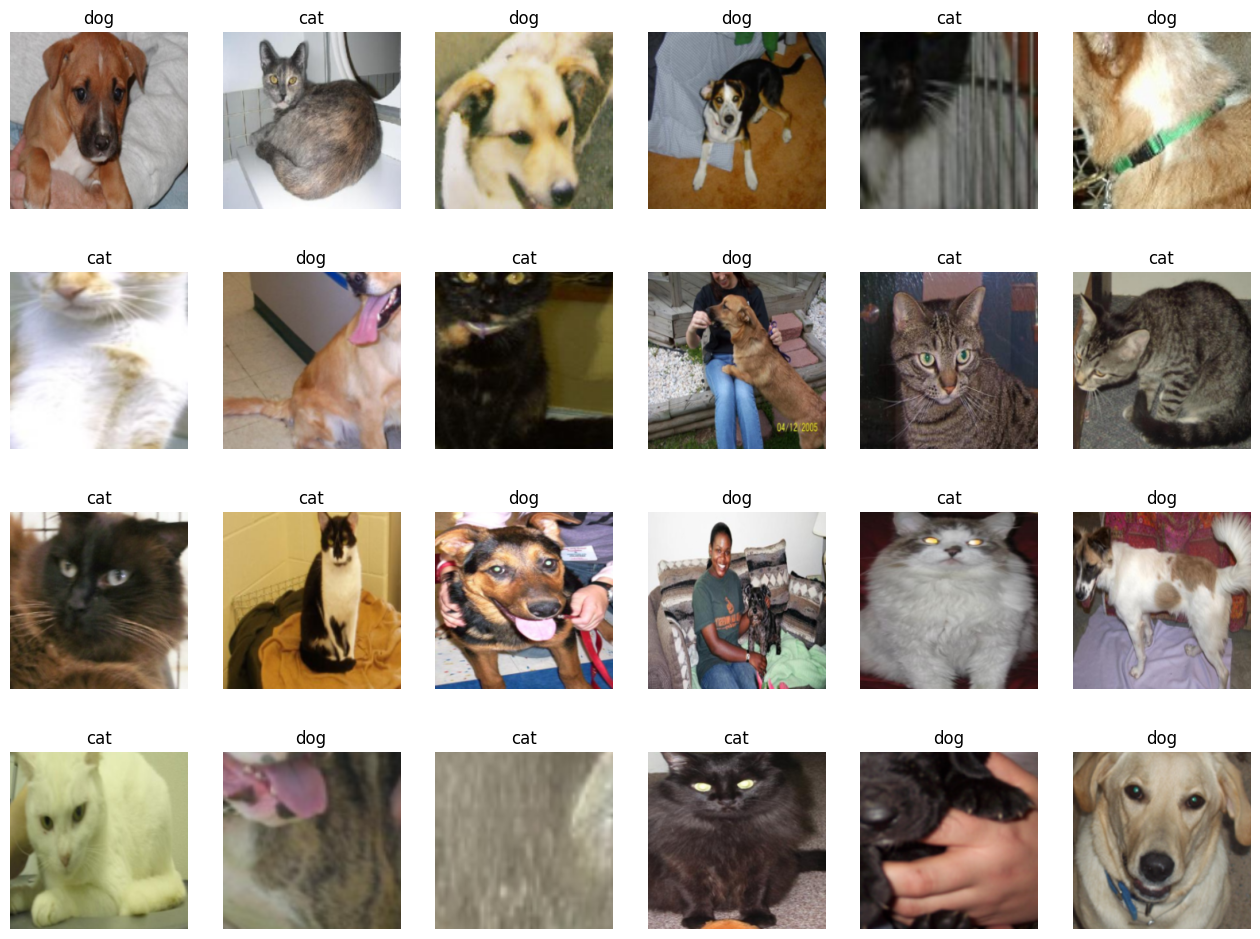

In [ ]:
# 학습에 사용될 이미지 출력
import numpy as np

samples, labels = next(iter(train_loader))
classes = {0:'cat', 1:'dog'} # 개와 고양이에 대한 클래스로 구성
fig = plt.figure(figsize=(16, 24))
for i in range(24): # 24개의 이미지 데이터 출력
    a = fig.add_subplot(4, 6, i+1)
    a.set_title(classes[labels[i].item()]) # 레이블 정보(클래스)를 함께 출력
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

- `iter()`: 전달된 데이터의 반복자를 꺼내서 반환.
- `next()`: 그 반복자가 다음에 출력해야할 요소를 반환.
즉, `iter()`로 반복자를 구하고 그 반복자를 `next()`에 전달하여 차례대로 꺼냄. train_loader에서 데이터를 하나씩 꺼내오겠다는 의미
- `np.transpose()`: 행과 열을 바꾸어 행렬의 차원을 바꿈. 내적 연산을 하기 위해 차원을 조정하는 경우가 많음.


```
# (2,3,4) 크기를 (4,3,2)로 변환
exam = np.arange(24).reshape(2,3,4)
np.transpose(exam, (2,1,0))
```



In [ ]:
# 사전 훈련된 ResNet18 모델 내려받기
resnet18 = models.resnet18(pretrained=True) # pretrained=True는 사전 학습된 가중치를 사용하겠다는 의미

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 308MB/s]


- ResNet18 모델
   - 50개의 계층으로 구성된 학습 합성곱 신경망
   - ImageNet 데이터베이스의 100만개가 넘는 영상을 훈련한 신경망으로 전이학습에 사용되도록 사전 훈련된 모델을 제공
   - 입력 제약이 매우 크고, 충분한 메모리(RAM)가 없으면 학습 속도가 느릴 수 있다는 단점이 있음.


In [ ]:
# 내려받은 ResNet18의 합성곱층을 사용하되 파라미터에 대해서는 학습을 하지 않도록 고정시킴.
def set_parameter_requires_grad(model, feature_extracting=True):
  if feature_extracting:
    for param in model.parameters():
      param.requires_grad = False

In [ ]:
set_parameter_requires_grad(resnet18)

- `param.requires_grad`: 역전파 중 파라미터들에 대한 변화를 계산할 필요성의 여부
   - 모델의 일부를 고정하고 나머지를 학습하고자할 때 `requires_grad=False`로 설정
   - 여기서 모델의 일부는 합성곱층과 풀링층을 의미

In [ ]:
# ResNet18 모델에 완전연결층 추가
resnet18.fc = nn.Linear(512, 2) # 2는 클래스가 두 개라는 의미

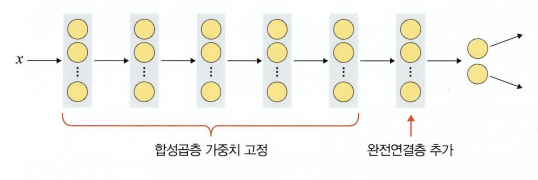

In [ ]:
# 모델의 파라미터값 확인
for name, param in resnet18.named_parameters(): # model.named_parameters()는 모델에 접근하여 파라미터 값들을 가져올 때 사용
   if param.requires_grad:
      print(name, param.data)

fc.weight tensor([[-0.0143,  0.0010, -0.0015,  ...,  0.0160,  0.0188, -0.0220],
        [ 0.0224, -0.0384, -0.0177,  ...,  0.0292, -0.0441, -0.0056]])
fc.bias tensor([-0.0211,  0.0313])


- 파라미터는 weight와 bias가 사용되고 있음.

In [ ]:
# 모델 학습 준비를 위해 모델의 객체를 생성하고 손실 함수를 정의
model = models.resnet18(pretrained=True) # 모델의 객체를 생성

for param in model.parameters(): # 모델의 합성곱층 가중치 고정
   param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters(): # 완전연결층은 학습
  param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss() # 손실함수 정의

print(model) # 완전연결층을 추가한 ResNet18 모델을 보여줌.

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 모델 학습을 위한 함수 생성
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs = 13, is_train=True):
    since = time.time() # 컴퓨터의 현재 시각을 구하는 함수
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs) : # 에포크(13)만큼 반복
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0.0

        for inputs, labels in dataloaders : # 데이터로더에 전달된 데이터만큼 반복
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad() # 기울기를 0으로 설정
            outputs = model(inputs) # 순전파 학습
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward() # 역전파 학습
            optimizer.step()

            running_loss += loss.item() * inputs.size(0) # 출력 결과와 레이블의 오차를 계산한 결과를 누적하여 저장
            running_corrects += torch.sum(preds == labels.data) # 출력 결과와 레이블이 동일한지 확인한 결과를 누적하여 저장

        epoch_loss = running_loss / len(dataloaders.dataset) # 평균 오차 계산
        epoch_acc = running_corrects.double() / len(dataloaders.dataset) # 평균 정확도 계산

        print('Loss: {:.4f} Acc {:.4f}'.format(epoch_loss, epoch_acc) )

        if epoch_acc > best_acc :
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('080289/chap05/data/catanddog',
                                                    '{0:0=2d}.pth'.format(epoch))) # 모델 재사용 위해 저장해둚.
        print()

    time_elapsed = time.time() - since # 실행시간(학습시간)을 계산
    print('Training complete in {:.0f}m {:.0f}s'. format(time_elapsed // 60,
                                                         time_elapsed % 60))
    print('Best Acc:{:4f}'.format(best_acc))
    return acc_history, loss_history # 모델 정확도와 오차를 반환

In [ ]:
# 학습을 통해 얻어지는 파라미터를 옵티마이저에 전달
params_to_update = []
for name, param in resnet18.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param) # 파라미터 학습 결과를 저장
    print('\t', name)

optimizer = optim.Adam(params_to_update) # 학습 결과를 옵티마이저에 전달

	 fc.weight
	 fc.bias


In [ ]:
# 모델 학습
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss() # 손실함수 지정
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.4056 Acc 0.8312

Epoch 1/12
----------
Loss: 0.3263 Acc 0.8753

Epoch 2/12
----------
Loss: 0.2683 Acc 0.9039

Epoch 3/12
----------
Loss: 0.2428 Acc 0.9091

Epoch 4/12
----------
Loss: 0.2516 Acc 0.8961

Epoch 5/12
----------
Loss: 0.2372 Acc 0.9117

Epoch 6/12
----------
Loss: 0.2108 Acc 0.9195

Epoch 7/12
----------
Loss: 0.2608 Acc 0.8961

Epoch 8/12
----------
Loss: 0.2459 Acc 0.8623

Epoch 9/12
----------
Loss: 0.2302 Acc 0.9065

Epoch 10/12
----------
Loss: 0.2351 Acc 0.8961

Epoch 11/12
----------
Loss: 0.1711 Acc 0.9403

Epoch 12/12
----------
Loss: 0.2376 Acc 0.8909

Training complete in 6m 25s
Best Acc:0.940260


- 모델 훈련을 위해 전달되는 파라미터는 (모델, 학습 데이터, 손실 함수, 옵티마이저, 장치(CPU 혹은 GPU))임.
- 약 94%의 상당히 높은 정확도를 보여줌.

In [ ]:
# 테스트 데이터 호출 및 전처리
test_path = '080289/chap05/data/catanddog/test'

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

test_dataset = torchvision.datasets.ImageFolder(
    root = test_path,
    transform = transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


In [ ]:
# 테스트 데이터 평가 함수 생성
def eval_model(model, dataloaders, device):
  since = time.time()
  acc_history = []
  best_acc = 0.0

  saved_models = glob.glob('080289/chap05/data/catanddog/' + '*.pth') # 현재 디렉터리에서 원하는 파일들만 추출하여 가져올 때 사용
  saved_models.sort() # 불러온 .pth 파일들을 정렬
  print('saved_model', saved_models)

  for model_path in saved_models:
    print('Loading model', model_path)

    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to(device)
    running_corrects = 0

    for inputs, labels in dataloaders: # 테스트 반복
      inputs = inputs.to(device)
      labels = labels.to(device)

      with torch.no_grad(): # autograd를 사용하지 않겠다는 의미
        outputs = model(inputs) # 데이터를 모델에 적용한 결과를 outputs에 저장

      _, preds = torch.max(outputs.data, 1) # 주어진 텐서 배열의 최댓값이 들어 있는 index를 반환
      preds[preds >= 0.5] = 1 # torch.max로 출력된 값이 0.5보다 크면 올바르게 예측
      preds[preds < 0.5] = 0 # torch.max로 출력된 값이 0.5보다 작으면 틀리게 예측
      running_corrects += preds.eq(labels.cpu()).int().sum() # preds 배열과 labels가 일치하는지 검사하는 용도로 사용.

    epoch_acc = running_corrects.double() / len(dataloaders.dataset) # 테스트 데이터의 정확도 계산
    print('Acc: {:.4f}'.format(epoch_acc))

    if epoch_acc > best_acc:
      best_acc = epoch_acc
      acc_history.append(epoch_acc.item())
      print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history # 계산된 정확도 반환

In [ ]:
# 테스트 데이터를 평가 함수에 적용
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['080289/chap05/data/catanddog/00.pth', '080289/chap05/data/catanddog/01.pth', '080289/chap05/data/catanddog/02.pth', '080289/chap05/data/catanddog/03.pth', '080289/chap05/data/catanddog/04.pth', '080289/chap05/data/catanddog/05.pth', '080289/chap05/data/catanddog/06.pth', '080289/chap05/data/catanddog/07.pth', '080289/chap05/data/catanddog/08.pth', '080289/chap05/data/catanddog/09.pth', '080289/chap05/data/catanddog/10.pth', '080289/chap05/data/catanddog/11.pth', '080289/chap05/data/catanddog/12.pth']
Loading model 080289/chap05/data/catanddog/00.pth
Acc: 0.8878

Validation complete in 0m 7s
Best Acc: 0.887755


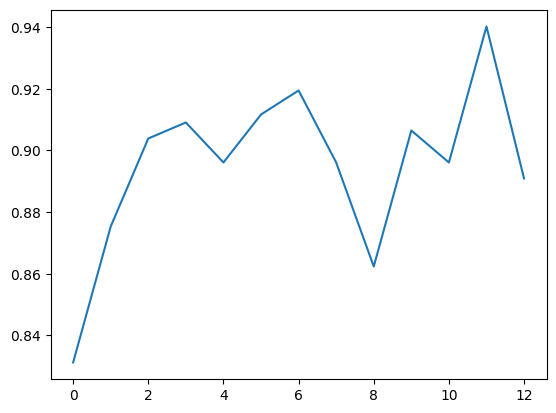

In [ ]:
# 각 에포크가 진행될 때마다 훈련과 테스트 데이터의 정확도를 그래프로 확인
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

- 에포크가 진행될수록 정확도가 100%에 가까워짐.

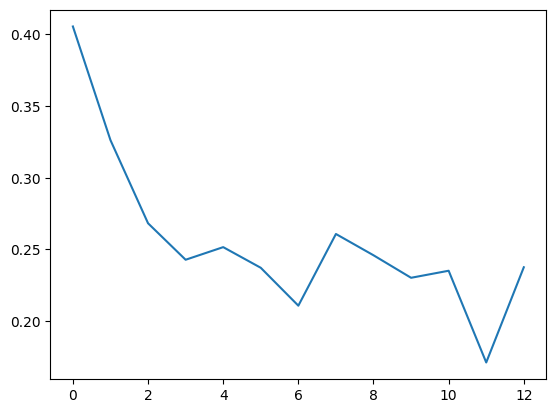

In [ ]:
# 훈련 데이터의 오차에 대한 그래프 확인
plt.plot(train_loss_hist)
plt.show()

- 에포크가 진행될수록 오차가 낮아짐. 학습이 잘 되고 있음.

실제 데이터를 잘 예측하는지 살펴보자.

In [ ]:
# 예측 이미지 출력을 위한 전처리 함수
def im_convert(tensor):
  image = tensor.clone().detach().numpy() # 기존 텐서를 복사한 세로운 텐서를 생성하지만 기울기에 영향을 주지는 않겠다는 의미
  image = image.transpose(1, 2, 0)
  image = image * (np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)))
  image = image.clip(0, 1) # 입력 값이 주어진 범위를 벗어날 때 입력값을 특정 법위로 제한시키기 위해 사용함.
  return image

- `tensor.clone()`, `tensor.detach()`, `tensor.clone().detach()`를 비교하는 표

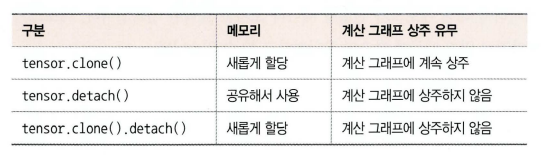

- 계산 그래프

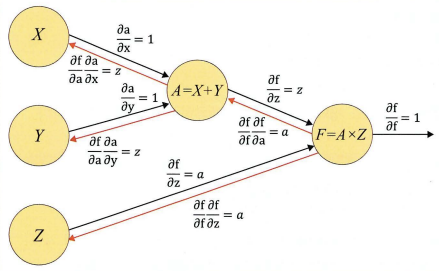

- 연쇄 법칙
   - 체인룰(chain rule): 두 개 이상의 함수가 결합된 함수, 즉 합성 함수의 미분법

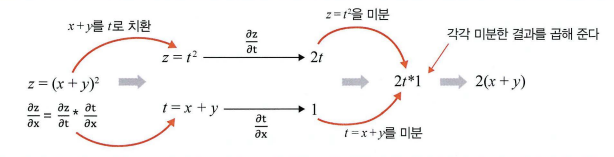

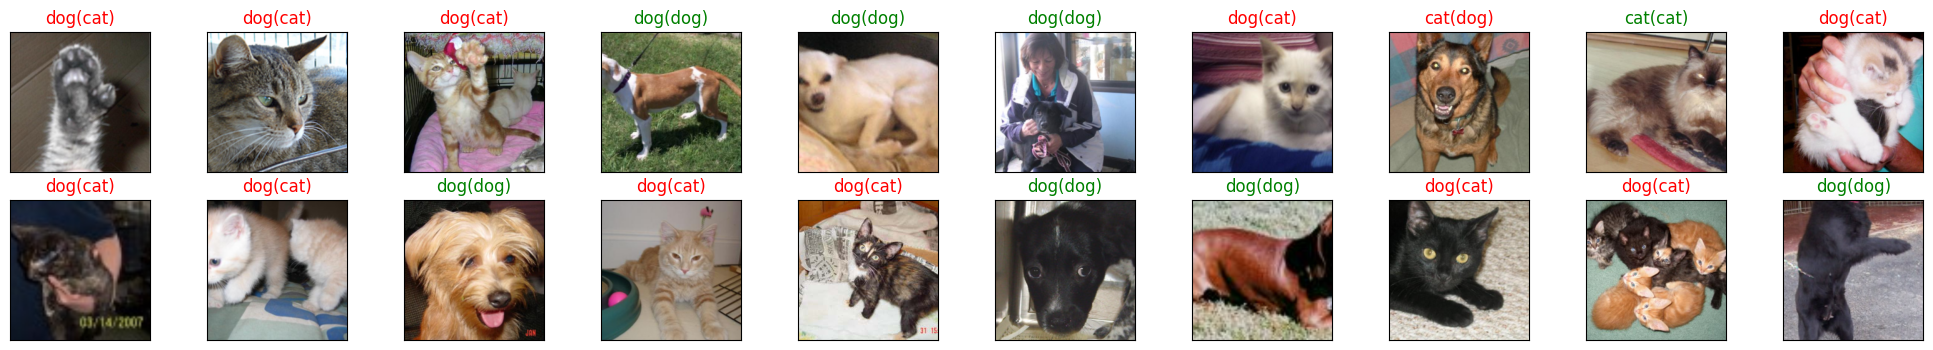

<Figure size 640x480 with 0 Axes>

In [ ]:
# 개와 고양이 예측 결과 출력
classes = {0:'cat', 1:'dog'} # 개와 고양이 두 개에 대한 레이블

dataiter = iter(test_loader) # 테스트 데이터셋을 가져옴.
images, labels = next(dataiter) # 테스트 데이터셋에서 이미지와 레이블을 분리하여 가져옴.
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) # 한 화면에 여러개의 이미지를 담기 위해 사용
    plt.imshow(im_convert(images[idx])) # 이미지 출력을 위해 im_convert 함수를 적용
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red")) # classes[preds[idx].item()]은 preds[idx].item()값이 classes로 정의된 0괴 1중 어떤 값을 갖는지 판별하겠다는 의미이다.
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0) # 서브플롯의 위치를 조정할 때 사용함.

- Figure 안에서 서브프롯의 위치를 조정할 수 있음. left, bottom, right, top으로 이밎의 위치를 조정
- hspace, wspace로 서브플롯 간의 간격도 조정 가능

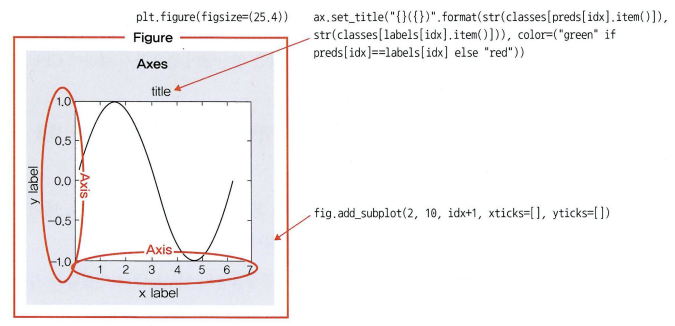

- 예측 결과가 정확하지 않음.
- 훈련 데이터를 더 늘리고, 에포크 횟수를 늘리면 더 좋은 결과를 얻을 수 있을 것임.

### 5.3.2 미세 조정 기법

: 사전 훈련된 네트워크를 미세 조정하여 분석하려는 데이터셋에 잘 맞도록 모델의 파라미터를 조정
- 특성 추출 기법에서 더 나아가 사전 훈련된 모델과 합성곱층, 데이터 분류기의 가중치를 업데이트하여 훈련시키는 방식
- 특성 추출이 잘못 되었다면 **미세 조정 기법**으로 새로운 이미지 데이터를 사용하여 네트워크의 가중치를 업데이트하여 특성을 다시 추출 가능
- 즉, 사전 학습된 모델을 목적에 맞게 재학습시키거나 학습된 가중치의 일부를 재학습시키는 것.
- 많은 연산량이 요구되기 때문에 CPU보단 GPU 사용 권장
- 파라미터 업데이트 과정에서 파라미터에 큰 변화를 주게 되면 과적합 문제가 발생할 수 있기 때문에 정교하고 미세한 파라미터 업데이터가 필요함.

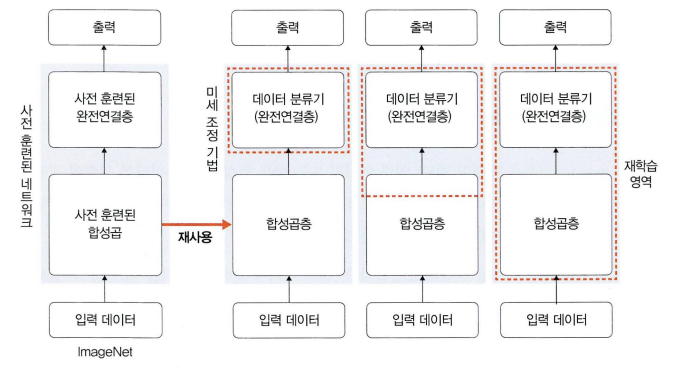